In [12]:
data_dir = "anime-data"
personalize_data_dir = "personalize-data"

# Exploración

In [13]:
!rm -rf {data_dir}/html\ folder
!ls -als {data_dir} -h

total 2.7G
4.0K drwxr-xr-x 2 root root 6.0K Sep  9 17:39 .
4.0K drwxr-xr-x 5 root root 6.0K Sep  9 19:33 ..
5.5M -rw-r--r-- 1 root root 5.5M Sep  9 17:34 anime.csv
6.9M -rw-r--r-- 1 root root 6.9M Sep  9 17:34 anime_with_synopsis.csv
1.9G -rw-r--r-- 1 root root 1.9G Sep  9 17:34 animelist.csv
781M -rw-r--r-- 1 root root 781M Sep  9 17:34 rating_complete.csv
4.0K -rw-r--r-- 1 root root   88 Sep  9 17:34 watching_status.csv


In [14]:
import time
from time import sleep
import random
from random import randrange
import json
import datetime
import boto3
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [15]:
anime = pd.read_csv(data_dir + '/anime.csv',index_col='MAL_ID')
anime.sample(1)

,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38623,Aware! Meisaku-kun: Q&A Corner,Unknown,"Comedy, Kids, Parody, School",Unknown,あはれ！名作くん Ｑ＆Ａコーナー,ONA,Unknown,"Aug 3, 2018 to ?",Unknown,Unknown,Unknown,Unknown,Original,1 min.,G - All Ages,13397.0,16448,118,0,24,0,11,42,41,3.0,Unknown,Unknown,1.0,2.0,2.0,1.0,2.0,1.0,4.0


### Podemos ver que este dataset no tiene una columna de tiempo, lo cual es necesario para entrenar el model. Más adelante  te mostrare como lo solucionamos. 

In [16]:
anime.describe(percentiles=[])

,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
50%,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
max,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


### Es un dataset con 17562 lineas, suficiente para entrenar un buen modelo.  

In [17]:
full_genre_list = []
for g in anime['Genres'][:10]:
    full_genre_list += g.replace(' ','').split(',')
genres, count  =  np.unique(full_genre_list, return_counts= True)

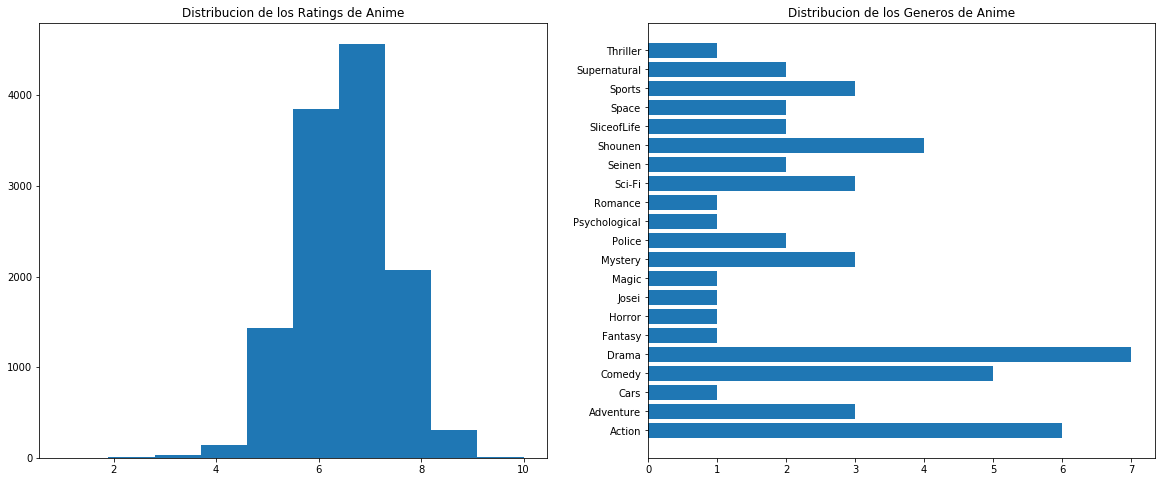

In [18]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

plt.subplot(1,2,1)
plt.hist(anime[anime.Score != 'Unknown']['Score'].astype(float),range=[1,10])
plt.title('Distribucion de los Ratings de Anime');

plt.subplot(1,2,2)
plt.barh(y= genres, width=count)
plt.title('Distribucion de los Generos de Anime');

In [19]:
anime_with_synopsis = pd.read_csv(data_dir + '/anime_with_synopsis.csv',index_col='MAL_ID')
anime_with_synopsis.sample(10)

,Name,Score,Genres,sypnopsis
MAL_ID,,,,
10238,Hybrid Deka,Unknown,Comedy,Himitsukessha Taka no Tsume spin-off movie spo...
5193,Shinjuku Shin-chan Patrol: Warui Otona ni Ki w...,Unknown,Kids,Free video hosted by Tokyo neighbourhood to pr...
38738,Kensaku to Enjin no Christmas,Unknown,Kids,ly 3DCG Christmas episode of Kensaku to Enjin .
6094,A Piece of Phantasmagoria,6.22,"Fantasy, Kids",collection of 15 short episodes depicting the ...
38464,Ashita Sekai ga Owaru toshitemo,6.41,"Drama, Romance",Shin Hazama has shut his heart ever since the ...
36991,Lupin III 3DCG,6.19,"Action, Thriller",Pilot for a hypothetical Lupin 3DCG project in...
39629,Aihime Megohime,Unknown,"Historical, Fantasy",No synopsis information has been added to this...
385,Gilgamesh,6.65,"Drama, Fantasy, Sci-Fi, Supernatural","The half-divine King of Uruk, Gilgamesh, was c..."
36291,Ling Yu,6.64,Fantasy,"In the world of Ling Yu(Spiritual Field), ther..."


In [20]:
anime_with_synopsis.describe(percentiles=[])

,Name,Score,Genres,sypnopsis
count,16214,16214,16214,16206
unique,16210,532,4857,15221
top,Maou Gakuin no Futekigousha: Shijou Saikyou no...,Unknown,Music,No synopsis information has been added to this...
freq,3,5123,790,709


In [21]:
watching_status = pd.read_csv(data_dir + '/watching_status.csv')
watching_status

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


### rating_complete
El rating del usuario que ha visto todo el anime

In [22]:
rating_complete = pd.read_csv(data_dir + '/rating_complete.csv')
rating_complete.sample(10)

,user_id,anime_id,rating
5297884,32492,16782,10
19675737,121013,1689,3
47445153,290954,6741,7
49020645,300428,3429,1
54046467,331220,1210,8
29610524,182247,28121,7
25143249,154903,8876,7
29672470,182541,10378,9
16125476,98969,9693,8
27244320,167746,25183,6


In [23]:
rating_complete.describe(percentiles=[])

,user_id,anime_id,rating
count,5.763328e+07,5.763328e+07,5.763328e+07
mean,1.768878e+05,1.583147e+04,7.510789e+00
std,1.020117e+05,1.326114e+04,1.697722e+00
min,0.000000e+00,1.000000e+00,1.000000e+00
50%,1.772910e+05,1.188700e+04,8.000000e+00
max,3.534040e+05,4.845600e+04,1.000000e+01


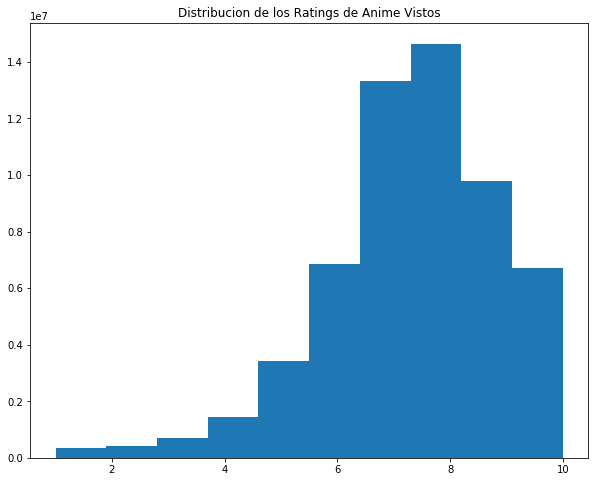

In [24]:
fig, ax = plt.subplots(figsize=(10,8))

plt.hist(rating_complete.rating,range=[1,10])
plt.title('Distribucion de los Ratings de Anime Vistos');

### Animelist

El rating del usuario y con el indicador de whatching status (todos los estados)

In [25]:
animelist = pd.read_csv(data_dir + '/animelist.csv', nrows=100)
animelist.sample(10)

,user_id,anime_id,rating,watching_status,watched_episodes
88,1,21,9,1,958
56,0,1887,0,3,2
14,0,1250,7,2,26
4,0,21,10,1,0
52,0,235,10,3,0
61,0,1735,0,4,6
17,0,430,9,2,1
38,0,1047,6,2,1
34,0,1074,0,2,1
77,1,7674,7,1,3


# Preparación del Dataset
## Interacciones

In [26]:
!mkdir $personalize_data_dir

In [27]:
print(rating_complete.isnull().any())
rating_complete.describe()

user_id     False
anime_id    False
rating      False
dtype: bool


,user_id,anime_id,rating
count,5.763328e+07,5.763328e+07,5.763328e+07
mean,1.768878e+05,1.583147e+04,7.510789e+00
std,1.020117e+05,1.326114e+04,1.697722e+00
min,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.827800e+04,3.091000e+03,7.000000e+00
50%,1.772910e+05,1.188700e+04,8.000000e+00
75%,2.654190e+05,2.899900e+04,9.000000e+00
max,3.534040e+05,4.845600e+04,1.000000e+01


Amazon Personalize requiere que las interacciones vengan con un TIMESTAMP, que no tenemos. 
Vamos a sintetizar esta información 
https://docs.aws.amazon.com/personalize/latest/dg/interactions-datasets.html#interactions-dataset-requirements


In [28]:
#Primero generamos un release date datetime basado en el año y un random 

def get_release_year(row):
    release_date = row['Premiered'].split(' ')
    year = 2020
    if len(release_date)>1:
        year = int(release_date[1])
        
    start_date = datetime.datetime(year, 1, 1)
    now =  datetime.datetime.today()
    time_between_dates = now - start_date
    days_between_dates = time_between_dates.days - 30
    random_number_of_days = random.randrange(days_between_dates*60*60*24)
    random_date = start_date + datetime.timedelta(seconds=random_number_of_days)
    return int(random_date.timestamp())

In [29]:
anime_copy = anime.copy()[['Name','Genres','Premiered','Studios','Rating']]
anime_copy['release_date']= anime_copy.apply(get_release_year, axis=1)
anime_copy.drop('Premiered', axis=1, inplace=True)
anime_copy.head()

,Name,Genres,Studios,Rating,release_date
MAL_ID,,,,,
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Sunrise,R - 17+ (violence & profanity),1030074835
5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Bones,R - 17+ (violence & profanity),1589229300
6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Madhouse,PG-13 - Teens 13 or older,1247397092
7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",Sunrise,PG-13 - Teens 13 or older,1450725298
8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",Toei Animation,PG - Children,1273748091


In [30]:
%%time
rating_with_date = rating_complete.join(anime_copy[['release_date']],on='anime_id')

CPU times: user 4.69 s, sys: 1.32 s, total: 6.01 s
Wall time: 6.01 s


In [31]:
%%time
now = int(datetime.datetime.today().timestamp())
rating_with_date['time_since_release']= (now - rating_with_date['release_date']) - 7

CPU times: user 363 ms, sys: 327 ms, total: 689 ms
Wall time: 270 ms


In [32]:
%%time
rating_with_date['random_seconds']= (rating_with_date['time_since_release']).apply(lambda x: randrange(x))

CPU times: user 56.6 s, sys: 2.75 s, total: 59.3 s
Wall time: 59.3 s


In [33]:
%%time
rating_with_date['TIMESTAMP'] = rating_with_date['release_date'] + rating_with_date['random_seconds']

CPU times: user 263 ms, sys: 210 ms, total: 474 ms
Wall time: 205 ms


In [34]:
interactions_df = rating_with_date[['user_id', 'anime_id', 'TIMESTAMP', 'rating']]

In [35]:
interactions_df.rename(columns = {'user_id':'USER_ID', 'anime_id':'ITEM_ID', 
                              'timestamp':'TIMESTAMP', 'rating': 'EVENT_VALUE' }, inplace = True) 
interactions_df['EVENT_TYPE'] = 'RATING'
interactions_df.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,USER_ID,ITEM_ID,TIMESTAMP,EVENT_VALUE,EVENT_TYPE
0,0,430,1606740270,9,RATING
1,0,1004,1629198387,5,RATING
2,0,3010,1350415759,7,RATING
3,0,570,1628916645,7,RATING
4,0,2762,1470721229,9,RATING


In [36]:
interactions_filename = "interactions.csv"
interactions_df.to_csv((personalize_data_dir+"/"+interactions_filename), index=False, float_format='%.0f')

In [37]:
!ls -alh {personalize_data_dir}/{interactions_filename}

-rw-r--r-- 1 root root 1.8G Sep 12 14:05 personalize-data/interactions.csv


## Creando el dataset groups y el interactions dataset

In [48]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

In [ ]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "personalize-anime"
)
dataset_group_arn = create_dataset_group_response['datasetGroupArn']

print(json.dumps(create_dataset_group_response, indent=2))

In [50]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(10)

DatasetGroup: CREATE PENDING
DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### Create the dataset

In [ ]:
interactions_schema = schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_VALUE",
            "type": "float"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },

    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "personalize-anime-interactions1",
    schema = json.dumps(interactions_schema)
)
interaction_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

In [ ]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-anime-interactions1",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interaction_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

## Configure an S3 bucket and an IAM role

In [54]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-west-2


In [56]:
s3 = boto3.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket_name = account_id + "-" + region + "-" + "personalize-anime-dataset1"
print(bucket_name)
if region == "us-east-1":
    s3.create_bucket(Bucket=bucket_name)
else:
    s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={'LocationConstraint': region}
        )

625806755153-us-west-2-personalize-anime-dataset1


In [57]:
interactions_file_path = personalize_data_dir + "/" + interactions_filename
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+interactions_filename

# Bucket Policy

In [58]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': 'S9BJ584FGA7JK4V0',
  'HostId': 'uVSYLgYMZVPMRLLpy9TXkgvoLNjYfgGrUexJRLQpY1HYhB7oPNjv/i6oTnXZ7FV/G85e2cJb3N0=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'uVSYLgYMZVPMRLLpy9TXkgvoLNjYfgGrUexJRLQpY1HYhB7oPNjv/i6oTnXZ7FV/G85e2cJb3N0=',
   'x-amz-request-id': 'S9BJ584FGA7JK4V0',
   'date': 'Sun, 12 Sep 2021 20:42:47 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

# crea Rol

In [ ]:
iam = boto3.client("iam")

role_name = "PersonalizeRoleAnime"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

## Import the interactions data

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "personalize-poc-anime-interactions",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)
dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

In [62]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(10)

DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: ACTIVE
CPU times: us

In [69]:
%store data_dir
%store personalize_data_dir
%store interactions_dataset_arn
%store dataset_group_arn
%store bucket_name
%store role_arn
%store role_name
%store data_dir
%store region
%store interaction_schema_arn

Stored 'data_dir' (str)
Stored 'personalize_data_dir' (str)
Stored 'interactions_dataset_arn' (str)
Stored 'dataset_group_arn' (str)
Stored 'bucket_name' (str)
Stored 'role_arn' (str)
Stored 'role_name' (str)
Stored 'data_dir' (str)
Stored 'region' (str)
Stored 'interaction_schema_arn' (str)


In [70]:
%store -r

# Validating and Importing Item Metadata

In [71]:
anime = pd.read_csv(data_dir + '/anime.csv',index_col='MAL_ID')
anime.sample(1)

,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
MAL_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
38909,Infinite Dendrogram,6.14,"Game, Fantasy",Infinite Dendrogram,<Infinite Dendrogram>-インフィニット・デンドログラム-,TV,13,"Jan 9, 2020 to Apr 16, 2020",Winter 2020,"AT-X, Nippon Columbia, KlockWorx, Hobby Japan,...",Funimation,NAZ,Light novel,23 min. per ep.,PG-13 - Teens 13 or older,7619.0,1277,113280,205,15817,53418,3636,13745,26664,1571.0,2072.0,5269.0,11096.0,11890.0,8253.0,4532.0,2103.0,1103.0,688.0


In [72]:
items = anime[['Name', 'Genres', 'Premiered', 'Studios' ]]
items['year'] = items['Premiered'].apply(lambda x: int(x.split(' ')[1]) if ' ' in x else 2000)
items['GENRE'] = items['Genres'].apply(lambda x: '|'.join(x.replace(' ', '').split(',')))
items.drop(['Name','Genres', 'Premiered'], axis=1,  inplace=True)
items.reset_index(inplace=True)
items.sample(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

,MAL_ID,Studios,year,GENRE
7283,15565,Xebec,2014,Action|Harem|SuperPower|Ecchi|MartialArts|School
3976,5131,Unknown,1976,Mecha|Sci-Fi
17156,42887,Unknown,2000,Kids|Music
8462,21485,Tatsunoko Production,1995,Adventure|Kids|SliceofLife
2424,2638,Unknown,2000,Kids|Adventure|Fantasy|Comedy|Shounen


In [73]:
itemmetadata_df = items.rename(columns = {'year':'YEAR', 'MAL_ID':'ITEM_ID', 'Studios':'STUDIOS'}) 

In [74]:
itemmetadata_filename = "item-meta.csv"
itemmetadata_df.to_csv((f"{personalize_data_dir}/{itemmetadata_filename}"), index=False, float_format='%.0f')

In [75]:
!ls -alh {personalize_data_dir}/{itemmetadata_filename}
!head {personalize_data_dir}/{itemmetadata_filename}

-rw-r--r-- 1 root root 748K Sep 12 21:02 personalize-data/item-meta.csv
ITEM_ID,STUDIOS,YEAR,GENRE
1,Sunrise,1998,Action|Adventure|Comedy|Drama|Sci-Fi|Space
5,Bones,2000,Action|Drama|Mystery|Sci-Fi|Space
6,Madhouse,1998,Action|Sci-Fi|Adventure|Comedy|Drama|Shounen
7,Sunrise,2002,Action|Mystery|Police|Supernatural|Drama|Magic
8,Toei Animation,2004,Adventure|Fantasy|Shounen|Supernatural
15,Gallop,2005,Action|Sports|Comedy|Shounen
16,J.C.Staff,2005,Comedy|Drama|Josei|Romance|SliceofLife
17,Nippon Animation,2002,SliceofLife|Comedy|Sports|Shounen
18,A.C.G.T.,2004,Action|Cars|Sports|Drama|Seinen


In [86]:
itemmetadata_df.sample(5)

,ITEM_ID,STUDIOS,YEAR,GENRE
5193,7939,Unknown,2000,Adventure|Fantasy|Comedy|Dementia|Music|Mystery
10849,31165,Unknown,2000,Drama
5648,9127,SynergySP,2000,Action|Comedy|Supernatural|Shounen
13902,36840,Lilix,2018,Ecchi|Romance|School
7613,17219,TMS Entertainment,2000,Kids|Fantasy|Comedy


In [76]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

### Create the dataset

In [ ]:
itemmetadata_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "STUDIOS",
            "type": "string",
            "categorical": True
        },
        {
            "name": "YEAR",
            "type": "int",
        },
        {
            "name": "GENRE",
            "type": "string",
            "categorical": True
        },

        
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "personalize-anime-item",
    schema = json.dumps(itemmetadata_schema)
)
itemmetadataschema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

In [ ]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-anime-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = itemmetadataschema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

### Upload data to S3

In [80]:
itemmetadata_file_path = f"{personalize_data_dir}/{itemmetadata_filename}"
boto3.Session().resource('s3').Bucket(bucket_name).Object(itemmetadata_filename).upload_file(itemmetadata_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+itemmetadata_filename

## Import the item metadata 

In [ ]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "personalize-anime-item-import",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, itemmetadata_filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

In [83]:
%%time

max_time = time.time() + 6*60*60 # 6 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(10)

DatasetImportJob: CREATE PENDING
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
DatasetImportJob: CREATE IN_PROGRESS
Datas

In [84]:
%store items_dataset_arn
%store itemmetadataschema_arn

Stored 'items_dataset_arn' (str)
Stored 'itemmetadataschema_arn' (str)


# Fin preparacion y exploracion

In [ ]:
%store